In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [73]:
df = pd.read_excel('Titanic.xlsx')
df.rename(columns={'2urvived': 'Survived'}, inplace=True)

# Remplir les valeurs manquantes avec la médiane
df.fillna(df.median(), inplace=True)

# Drop la colonne passenger ID
df.drop(columns=['Passengerid'], inplace=True)

In [55]:
df.describe()

,Age,Fare,Sex,sibsp,Parch,Pclass,Embarked,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.503186,33.281086,0.355997,0.498854,0.385027,2.294882,1.493506,0.261268
std,12.905241,51.741500,0.478997,1.041658,0.865560,0.837836,0.814244,0.439494
min,0.170000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,22.000000,7.895800,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000
75%,35.000000,31.275000,1.000000,1.000000,0.000000,3.000000,2.000000,1.000000
max,80.000000,512.329200,1.000000,8.000000,9.000000,3.000000,2.000000,1.000000


In [74]:
#Compter le nombre de passager qui ont voyagé gratuitement
free = (df['Fare'] == 0).sum()
print(f"Nombre de passagers avec un Fare de 0 : {free}")


Nombre de passagers avec un Fare de 0 : 17


In [75]:
# Définir les features (X) et la variable cible (y)
X = df.drop(columns=['Survived']) 
y = df['Survived']  

In [59]:
# Séparer en 80% training et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=756)

# Vérifier les tailles des jeux de données
print(f"Taille du dataset d'entraînement : {X_train.shape}")
print(f"Taille du dataset de test : {X_test.shape}")

Taille du dataset d'entraînement : (1047, 7)
Taille du dataset de test : (262, 7)


In [76]:
# Normaliser les données 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [77]:
# Créer le modèle
model = LogisticRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


In [78]:
# Récupérer les coefficients du modèle
coefficients = pd.DataFrame(model.coef_[0], index=X.columns, columns=['Coefficient'])

# Trier par importance (valeurs absolues)
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)

print(coefficients)


          Coefficient
Sex          0.975679
Pclass      -0.726867
Age         -0.375705
sibsp       -0.143379
Fare        -0.101179
Embarked    -0.014899
Parch       -0.010794


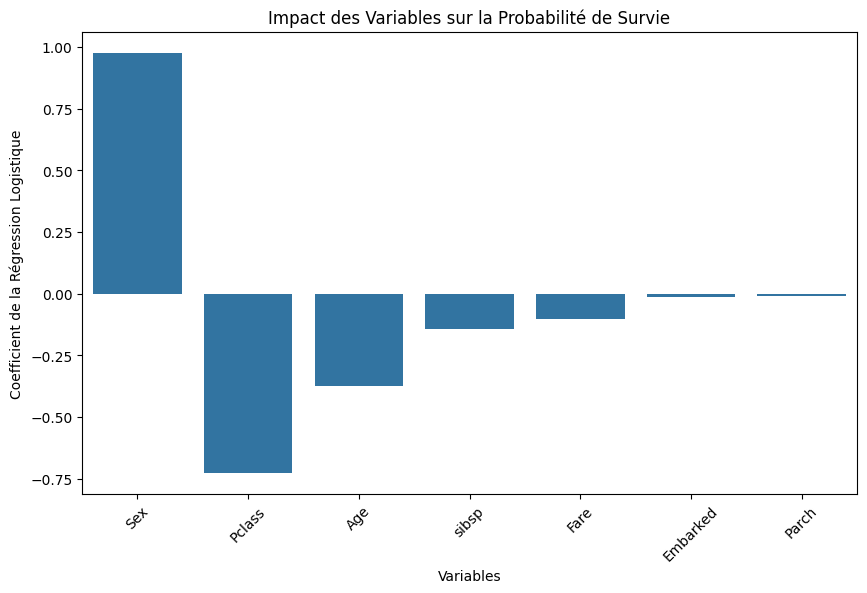

In [71]:

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.index, y=coefficients['Coefficient'])
plt.xticks(rotation=45)
plt.title("Impact des Variables sur la Probabilité de Survie")
plt.xlabel("Variables")
plt.ylabel("Coefficient de la Régression Logistique")
plt.show()


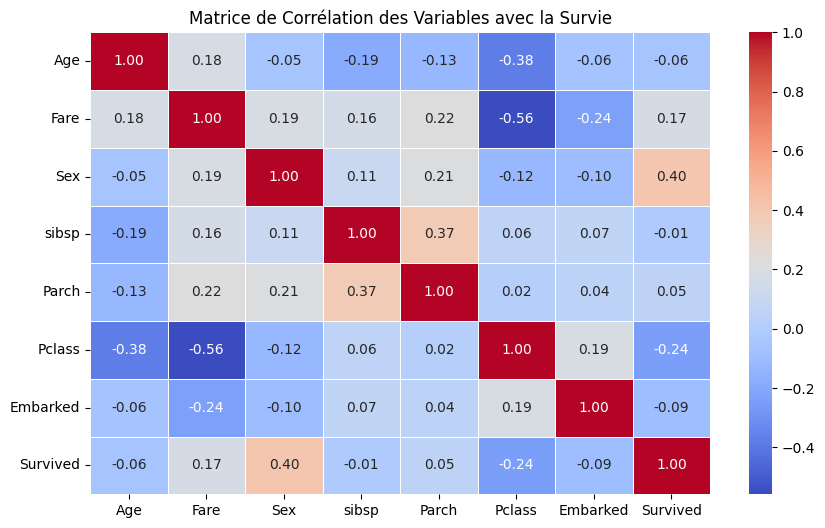

In [79]:
# Calculer la matrice de corrélation
correlation_matrix = df.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation des Variables avec la Survie")
plt.show()


Sex (Sex = 1 pour les femmes) → Coefficient positif élevé
Être une femme augmentait considérablement les chances de survie.

Pclass (Classe de cabine) → Coefficient négatif
Les passagers de 1ère classe avaient plus de chances de survivre que ceux de 3ème classe.

Fare (Prix du billet) → Coefficient positif
Les personnes ayant payé un billet plus cher avaient plus de chances de survivre.

Age → Coefficient négatif
Les personnes plus jeunes avaient plus de chances de survivre que les plus âgées.

Implication historique :
Ces résultats confirment les règles appliquées lors du naufrage :
“Les femmes et les enfants d'abord”
Les riches avaient plus de places dans les canots de sauvetage.

Rapport de classification :
              precision    recall  f1-score     support
0              0.791855  0.911458  0.847458  192.000000
1              0.585366  0.342857  0.432432   70.000000
accuracy       0.759542  0.759542  0.759542    0.759542
macro avg      0.688611  0.627158  0.639945  262.000000
weighted avg   0.736686  0.759542  0.736573  262.000000


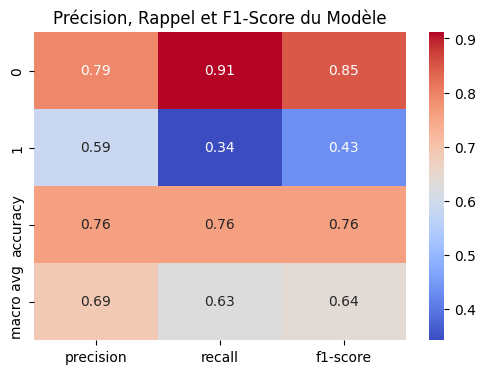

In [80]:
# Afficher le rapport de classification
report = classification_report(y_test, y_pred, output_dict=True)

# Transformer en DataFrame pour affichage plus clair
df_report = pd.DataFrame(report).transpose()

print("Rapport de classification :")
print(df_report)

# Afficher graphiquement les scores
plt.figure(figsize=(6, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Précision, Rappel et F1-Score du Modèle")
plt.show()

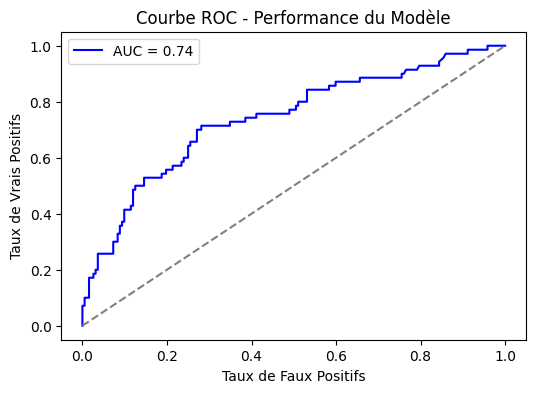

In [81]:

# Calculer les probabilités prédites pour la classe survivant (1)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # Ligne de référence
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Performance du Modèle")
plt.legend()
plt.show()
